In [1]:
import sys

import constants
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap
from PyComplexHeatmap import *
from scipy.stats import pearsonr
from sklearn.cluster import KMeans

sys.path.insert(1, "../helper_functions")
from helper_functions import prepare_bulk

In [2]:
newcmp = sns.color_palette("vlag", 6)[1:]
newcmp[1] = (1, 1, 1)
newcmp = ListedColormap(newcmp, "my_cmap3")
col = constants.COL

## Bulk

In [3]:
bulk195 = prepare_bulk("../data/p195_1MB_per_bin_calls_long.bed")
bulk63 = prepare_bulk("../data/p63_1MB_per_bin_calls_long.bed")
bulk195_100kb = prepare_bulk(
    "../data/readcounts.100kb.cell_bc_p195_per_bin_calls_long.bed"
)
bulk63_100kb = prepare_bulk(
    "../data/readcounts.100kb.cell_bc_p63_per_bin_calls_long.bed"
)

In [4]:
cut_chroms = bulk63[["chrom_num"]].copy()
cut_chroms.chrom_num = cut_chroms.chrom_num.astype(str)
cut_chroms.columns = ["chromosome"]
cut_chroms = cut_chroms.replace({"23": "X"})

# DEFND - DNA

In [5]:
defnd = pd.read_csv("../data/CNVs_DEFND_filtered.csv.gz", index_col=0)

In [6]:
defnd = defnd.reindex(columns=cut_chroms.index)

In [7]:
kmeans = KMeans(n_clusters=2, random_state=42)  # Number of clusters
kmeans.fit(defnd)

KMeans(n_clusters=2, random_state=42)

In [8]:
labels = kmeans.labels_

In [9]:
df1 = pd.DataFrame(
    [
        defnd.apply(
            lambda row: pearsonr(row, bulk195.loc[cut_chroms.index].CN)[0], axis=1
        ),
        defnd.apply(
            lambda row: pearsonr(row, bulk63.loc[cut_chroms.index].CN)[0], axis=1
        ),
    ]
)

/var/folders/zr/5fr8vc4j0ld_zppj3b771d700000gr/T/ipykernel_87019/3055818082.py:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  lambda row: pearsonr(row, bulk195.loc[cut_chroms.index].CN)[0], axis=1
/var/folders/zr/5fr8vc4j0ld_zppj3b771d700000gr/T/ipykernel_87019/3055818082.py:7: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  lambda row: pearsonr(row, bulk63.loc[cut_chroms.index].CN)[0], axis=1


In [10]:
df1 = df1.T
df1.columns = ["bulk_p195", "bulk_p63"]
df1["cluster"] = labels
# Switching clusters so it matches other samples
df1["cluster"] = df1["cluster"].replace(0, "Cluster 1")
df1["cluster"] = df1["cluster"].replace(1, "Cluster 0")

<Figure size 600x600 with 0 Axes>

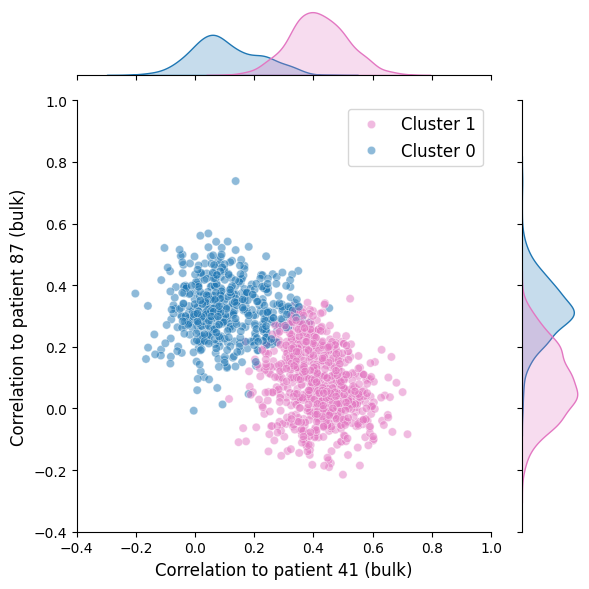

In [11]:
plt.figure(figsize=(6, 6))
joint_plot = sns.jointplot(
    x="bulk_p63",
    y="bulk_p195",
    data=df1,
    hue="cluster",
    alpha=0.5,
    palette={
        "Cluster 1": sns.palettes.color_palette("tab10")[6],
        "Cluster 0": sns.palettes.color_palette("tab10")[0],
    },
)

plt.xlabel("Correlation to patient 41 (bulk)", fontsize=12)
plt.ylabel("Correlation to patient 87 (bulk)", fontsize=12)
plt.xlim(-0.4, 1)
plt.ylim(-0.4, 1)
plt.legend(fontsize=12)
plt.tight_layout()

plt.savefig("figures_rebuttal/correlation_defnd_rebuttal.png", dpi=300)
plt.savefig("figures_rebuttal/correlation_defnd_rebuttal.svg", dpi=300)

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..


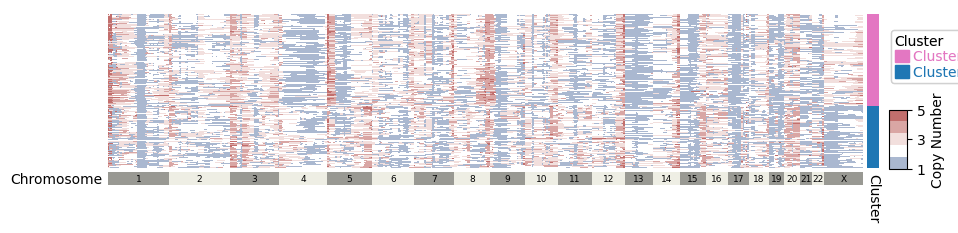

In [12]:
plt.figure(figsize=(10, 2))

col_ha = HeatmapAnnotation(
    Chromosome=anno_simple(
        cut_chroms.chromosome, add_text=True, colors=col, text_kws={"color": "black"}
    ),
    plot_legend=False,
    axis=1,
    rasterized=True,
    label_side="left",
    verbose=0,
)
row_ha = HeatmapAnnotation(
    Cluster=anno_simple(
        df1.cluster,
        add_text=False,
        colors={
            "Cluster 1": sns.palettes.color_palette("tab10")[6],
            "Cluster 0": sns.palettes.color_palette("tab10")[0],
        },
    ),
    plot_legend=True,
    axis=0,
    rasterized=True,
    label_side="bottom",
)

cm1 = ClusterMapPlotter(
    data=defnd[cut_chroms.index],
    row_dendrogram=False,
    show_rownames=False,
    show_colnames=False,
    bottom_annotation=col_ha,
    right_annotation=row_ha,
    row_cluster_metric="cityblock",
    row_cluster_method="ward",
    col_cluster=False,
    row_cluster=True,
    label="Copy Number",
    cmap=newcmp,
    rasterized=True,
    row_split=df1.cluster,
    row_split_gap=0,
    row_split_order=["Cluster 1", "Cluster 0"],
)

plt.savefig("figures_rebuttal/defend_mix_singlecell_2.png", dpi=300)
plt.savefig("figures_rebuttal/defend_mix_singlecell_2.svg", dpi=300)
plt.show()

In [13]:
df1.value_counts("cluster") / df1.value_counts("cluster").sum()

cluster
Cluster 1    0.597267
Cluster 0    0.402733
Name: count, dtype: float64

### Metacells

In [14]:
defnd = pd.read_csv("../data/CNVs_DEFND_metacells.csv.gz", index_col=0)
defnd

,chr1:1-100001,chr1:400001-500001,chr1:800001-900001,chr1:1200001-1300001,chr1:1600001-1700001,chr1:2100001-2200001,chr1:2500001-2600001,chr1:2900001-3000001,chr1:3300001-3400001,chr1:3700001-3800001,...,chrY:53400001-53500001,chrY:54500001-54600001,chrY:55500001-55600001,chrY:56600001-56700001,chrY:8300001-8400001,chrY:16700001-16800001,chrY:25100001-25200001,chrY:33500001-33600001,chrY:41900001-42000001,chrY:50300001-50400001
1416_per_bin_calls_long,5,5,5,5,5,5,5,5,5,5,...,1,1,1,1,1,1,1,1,1,1
1192_per_bin_calls_long,2,2,2,2,2,2,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1
1364_per_bin_calls_long,1,1,1,1,1,5,5,5,5,5,...,1,1,1,1,1,1,1,1,1,1
1323_per_bin_calls_long,5,5,5,5,5,5,5,5,5,5,...,1,1,1,1,1,1,1,1,1,1
1342_per_bin_calls_long,1,1,1,1,1,1,5,5,5,5,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152_per_bin_calls_long,5,5,5,5,5,5,5,5,5,5,...,1,1,1,1,1,1,1,1,1,1
1347_per_bin_calls_long,5,5,5,5,5,5,5,5,5,5,...,1,1,1,1,1,1,1,1,1,1
1414_per_bin_calls_long,4,4,4,4,4,4,4,4,4,4,...,1,1,1,1,1,1,1,1,1,1
707_per_bin_calls_long,1,1,1,1,1,1,1,5,5,5,...,1,1,1,1,1,1,1,1,1,1


In [15]:
cut_chroms = bulk63_100kb[["chrom_num"]].copy()
cut_chroms.chrom_num = cut_chroms.chrom_num.astype(str)
cut_chroms.columns = ["chromosome"]
cut_chroms = cut_chroms.replace({"23": "X"})

In [16]:
defnd = defnd.reindex(columns=cut_chroms.index)

In [17]:
kmeans = KMeans(n_clusters=2, random_state=42)  # Number of clusters
kmeans.fit(defnd)

KMeans(n_clusters=2, random_state=42)

In [18]:
df_metacells = pd.DataFrame(
    [
        defnd.apply(
            lambda row: pearsonr(row, bulk195_100kb.loc[cut_chroms.index].CN)[0], axis=1
        ),
        defnd.apply(
            lambda row: pearsonr(row, bulk63_100kb.loc[cut_chroms.index].CN)[0], axis=1
        ),
    ]
)

In [19]:
labels = kmeans.labels_
df_metacells = df_metacells.T
df_metacells.columns = ["bulk_p195", "bulk_p63"]

In [20]:
df_metacells["cluster"] = labels
df_metacells["cluster"] = df_metacells["cluster"].replace(0, "Cluster 0")
df_metacells["cluster"] = df_metacells["cluster"].replace(1, "Cluster 1")

/var/folders/zr/5fr8vc4j0ld_zppj3b771d700000gr/T/ipykernel_87019/3606014987.py:22: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 600x600 with 0 Axes>

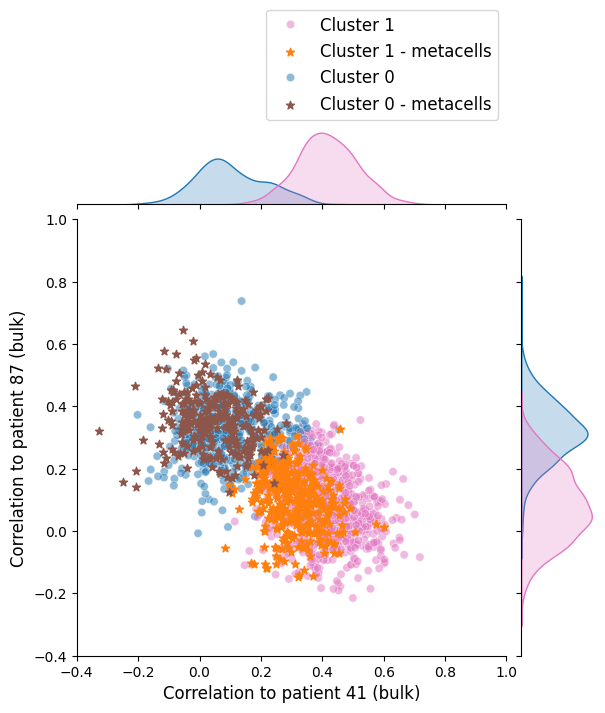

In [21]:
plt.figure(figsize=(6, 6))
joint_plot = sns.jointplot(
    x="bulk_p63",
    y="bulk_p195",
    data=df1,
    hue="cluster",
    alpha=0.5,
    palette={
        "Cluster 1": sns.palettes.color_palette("tab10")[6],
        "Cluster 0": sns.palettes.color_palette("tab10")[0],
    },
)

joint_plot.ax_joint.scatter(
    df_metacells[df_metacells["cluster"] == "Cluster 1"]["bulk_p63"],
    df_metacells[df_metacells["cluster"] == "Cluster 1"]["bulk_p195"],
    c=[sns.palettes.color_palette("tab10")[1]],
    marker="*",
    label="Cluster 1 - metacells",
)
joint_plot.ax_joint.scatter(
    df_metacells[df_metacells["cluster"] == "Cluster 0"]["bulk_p63"],
    df_metacells[df_metacells["cluster"] == "Cluster 0"]["bulk_p195"],
    c=[sns.palettes.color_palette("tab10")[5]],
    marker="*",
    label="Cluster 0 - metacells",
)

handles, labels = plt.gca().get_legend_handles_labels()
order = ["Cluster 1", "Cluster 1 - metacells", "Cluster 0", "Cluster 0 - metacells"]
# Specify the desired order of labels
handles = [handles[labels.index(label)] for label in order]
labels = order

# Update the legend
plt.legend(handles, labels, bbox_to_anchor=(1, 1.5), fontsize=12)
plt.xlabel("Correlation to patient 41 (bulk)", fontsize=12)
plt.ylabel("Correlation to patient 87 (bulk)", fontsize=12)
plt.xlim(-0.4, 1)
plt.ylim(-0.4, 1)
plt.tight_layout()

plt.savefig("figures_rebuttal/correlation_defnd_metacells.png", dpi=300)
plt.savefig("figures_rebuttal/correlation_defnd_metacells.svg", dpi=300)

In [22]:
df_metacells.value_counts("cluster") / df_metacells.value_counts("cluster").sum()

cluster
Cluster 1    0.591195
Cluster 0    0.408805
Name: count, dtype: float64

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..


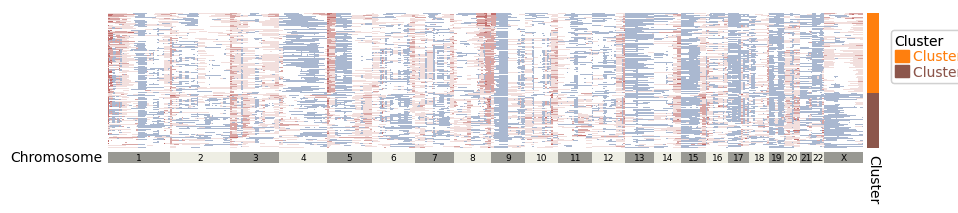

In [23]:
plt.figure(figsize=(10, 2))

col_ha = HeatmapAnnotation(
    Chromosome=anno_simple(
        cut_chroms.chromosome, add_text=True, colors=col, text_kws={"color": "black"}
    ),
    plot_legend=False,
    axis=1,
    rasterized=True,
    label_side="left",
    verbose=0,
)
row_ha = HeatmapAnnotation(
    Cluster=anno_simple(
        df_metacells.cluster,
        add_text=False,
        colors={
            "Cluster 1": sns.palettes.color_palette("tab10")[1],
            "Cluster 0": sns.palettes.color_palette("tab10")[5],
        },
    ),
    plot_legend=True,
    axis=0,
    rasterized=True,
    label_side="bottom",
)

cm1 = ClusterMapPlotter(
    data=defnd[cut_chroms.index],
    row_dendrogram=False,
    show_rownames=False,
    show_colnames=False,
    bottom_annotation=col_ha,
    right_annotation=row_ha,
    row_cluster_metric="cityblock",
    row_cluster_method="ward",
    col_cluster=False,
    row_cluster=True,
    label="Copy Number",
    cmap=newcmp,
    rasterized=True,
    legend=False,
    row_split=df_metacells.cluster,
    row_split_gap=0,
    row_split_order=["Cluster 1", "Cluster 0"],
)

plt.savefig("figures_rebuttal/defend_mix_final_metacells.png", dpi=300)
plt.savefig("figures_rebuttal/defend_mix_final_metacells.svg", dpi=300)
plt.show()

### HIPSDR for comparison

In [24]:
cna = pd.read_csv("../data/CNVs_HIPSDR_filtered.csv.gz", index_col=0)
cna

,chr1:1-1000001,chr1:1000001-2000001,chr1:2000001-3000001,chr1:3000001-4000001,chr1:4000001-5000001,chr1:5000001-6000001,chr1:6000001-7000001,chr1:7000001-8000001,chr1:8000001-9000001,chr1:9000001-10000001,...,chrY:48000001-49000001,chrY:49000001-50000001,chrY:50000001-51000001,chrY:51000001-52000001,chrY:52000001-53000001,chrY:53000001-54000001,chrY:54000001-55000001,chrY:55000001-56000001,chrY:56000001-57000001,chrY:57000001-58000001
TTCAGGTAGTAAGAAC-1,4,4,4,4,4,4,4,4,4,4,...,2,2,2,2,2,2,2,2,2,2
TGCAGGCTCGGTTTGG-1,4,4,4,4,4,4,4,4,4,4,...,1,1,1,1,1,1,1,1,1,1
CCTTATGTCTAGCGAT-1,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
TACTTCGTCGCCTAAG-1,4,4,4,4,4,4,4,4,4,4,...,1,1,1,1,1,1,1,1,1,1
AGGTATTGTAGGTTGC-1,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CAAACTGGTAACCACA-1,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
ACGCAAGCACGTTACA-1,3,3,3,3,3,3,3,3,3,3,...,2,2,2,2,2,2,2,2,2,2
AATCCGTAGGTTTACA-1,3,3,3,3,3,3,3,3,3,3,...,1,1,1,1,1,1,1,1,1,1
TCCCGTTAGCTCAAAC-1,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2


In [25]:
cut_chroms = bulk63[["chrom_num"]].copy()
cut_chroms.chrom_num = cut_chroms.chrom_num.astype(str)
cut_chroms.columns = ["chromosome"]
cut_chroms = cut_chroms.replace({"23": "X"})

In [26]:
cna = cna.reindex(columns=cut_chroms.index)

In [27]:
kmeans = KMeans(n_clusters=2, random_state=42)  # Number of clusters
kmeans.fit(cna)

KMeans(n_clusters=2, random_state=42)

In [28]:
labels = kmeans.labels_

In [29]:
df1 = pd.DataFrame(
    [
        cna.apply(
            lambda row: pearsonr(row, bulk195.loc[cut_chroms.index].CN)[0], axis=1
        ),
        cna.apply(
            lambda row: pearsonr(row, bulk63.loc[cut_chroms.index].CN)[0], axis=1
        ),
    ]
)

In [30]:
df1 = df1.T
df1.columns = ["bulk_p195", "bulk_p63"]

In [31]:
df1["clusters"] = labels
df1["clusters"] = df1["clusters"].replace(0, "Cluster 0")
df1["clusters"] = df1["clusters"].replace(1, "Cluster 1")

<Figure size 600x600 with 0 Axes>

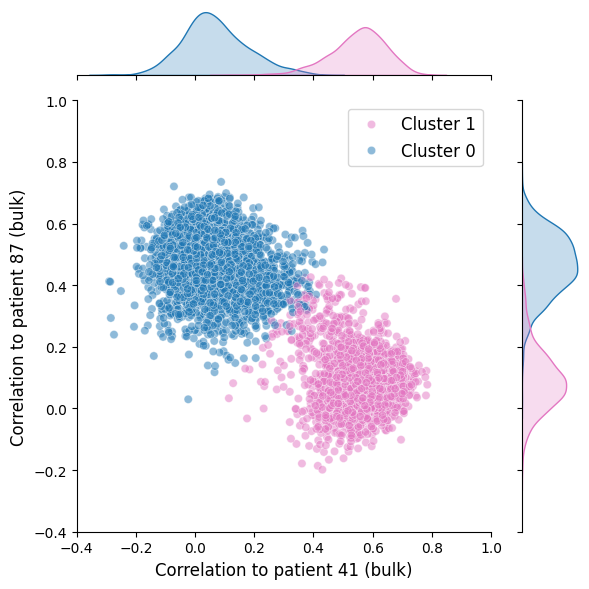

In [32]:
plt.figure(figsize=(6, 6))
joint_plot = sns.jointplot(
    x="bulk_p63",
    y="bulk_p195",
    data=df1,
    hue="clusters",
    alpha=0.5,
    palette={
        "Cluster 1": sns.palettes.color_palette("tab10")[6],
        "Cluster 0": sns.palettes.color_palette("tab10")[0],
    },
)

plt.xlabel("Correlation to patient 41 (bulk)", fontsize=12)
plt.ylabel("Correlation to patient 87 (bulk)", fontsize=12)
plt.xlim(-0.4, 1)
plt.ylim(-0.4, 1)
plt.legend(fontsize=12)
plt.tight_layout()

plt.savefig("figures_rebuttal/correlation_hipsdr_defnd_rebuttal.png", dpi=300)
plt.savefig("figures_rebuttal/correlation_hipsdr_defnd_rebuttal.svg", dpi=300)

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..


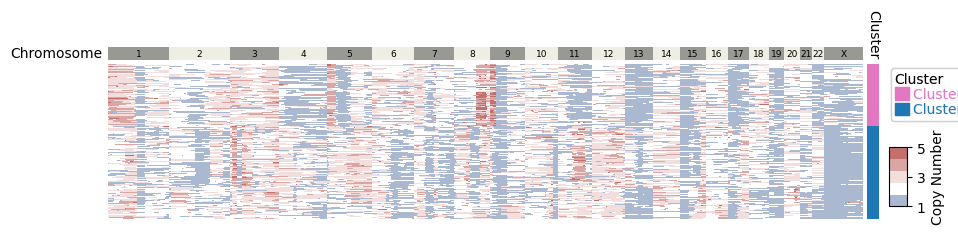

In [33]:
plt.figure(figsize=(10, 2))

col_ha = HeatmapAnnotation(
    Chromosome=anno_simple(
        cut_chroms.chromosome, add_text=True, colors=col, text_kws={"color": "black"}
    ),
    plot_legend=False,
    axis=1,
    rasterized=True,
    label_side="left",
    verbose=0,
)
row_ha = HeatmapAnnotation(
    Cluster=anno_simple(
        df1.clusters,
        add_text=False,
        colors={
            "Cluster 1": sns.palettes.color_palette("tab10")[6],
            "Cluster 0": sns.palettes.color_palette("tab10")[0],
        },
    ),
    plot_legend=True,
    axis=0,
    rasterized=True,
)
cm1 = ClusterMapPlotter(
    data=cna[cut_chroms.index],
    row_dendrogram=False,
    show_rownames=False,
    show_colnames=False,
    top_annotation=col_ha,
    right_annotation=row_ha,
    row_cluster_metric="cityblock",
    row_cluster_method="ward",
    col_cluster=False,
    row_cluster=True,
    label="Copy Number",
    cmap=newcmp,
    rasterized=True,
    row_split=df1.clusters,
    row_split_gap=0,
    row_split_order=["Cluster 1", "Cluster 0"],
)

plt.savefig("figures_rebuttal/hipsdr_for_defnd.png", dpi=300)
plt.savefig("figures_rebuttal/hipsdr_for_defnd.svg", dpi=300)
plt.show()

In [34]:
metacells = pd.read_csv("../data/CNVs_HIPSDR_metacells_100kb.csv.gz", index_col=0)

In [35]:
cut_chroms = bulk63_100kb[["chrom_num"]].copy()
cut_chroms.chrom_num = cut_chroms.chrom_num.astype(str)
cut_chroms.columns = ["chromosome"]
cut_chroms = cut_chroms.replace({"23": "X"})

In [36]:
metacells = metacells.reindex(columns=cut_chroms.index)

In [37]:
df_metacells = pd.DataFrame(
    [
        metacells.apply(
            lambda row: pearsonr(row, bulk195_100kb.loc[cut_chroms.index].CN)[0], axis=1
        ),
        metacells.apply(
            lambda row: pearsonr(row, bulk63_100kb.loc[cut_chroms.index].CN)[0], axis=1
        ),
    ]
)

In [38]:
kmeans = KMeans(n_clusters=2, random_state=42)  # Number of clusters
kmeans.fit(metacells)

KMeans(n_clusters=2, random_state=42)

In [39]:
labels = kmeans.labels_
df_metacells = df_metacells.T
df_metacells.columns = ["bulk_p195", "bulk_p63"]

In [40]:
df_metacells["cluster"] = labels
df_metacells["cluster"] = df_metacells["cluster"].replace(0, "Cluster 0")
df_metacells["cluster"] = df_metacells["cluster"].replace(1, "Cluster 1")

/var/folders/zr/5fr8vc4j0ld_zppj3b771d700000gr/T/ipykernel_87019/1325004696.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


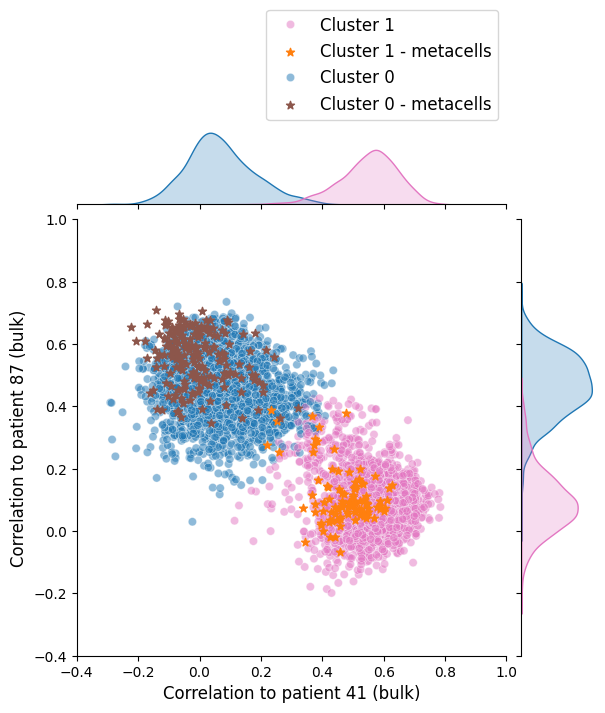

In [41]:
joint_plot = sns.jointplot(
    x="bulk_p63",
    y="bulk_p195",
    data=df1,
    hue="clusters",
    alpha=0.5,
    palette={
        "Cluster 1": sns.palettes.color_palette("tab10")[6],
        "Cluster 0": sns.palettes.color_palette("tab10")[0],
    },
)

joint_plot.ax_joint.scatter(
    df_metacells[df_metacells["cluster"] == "Cluster 1"]["bulk_p63"],
    df_metacells[df_metacells["cluster"] == "Cluster 1"]["bulk_p195"],
    c=[sns.palettes.color_palette("tab10")[1]],
    marker="*",
    label="Cluster 1 - metacells",
)
joint_plot.ax_joint.scatter(
    df_metacells[df_metacells["cluster"] == "Cluster 0"]["bulk_p63"],
    df_metacells[df_metacells["cluster"] == "Cluster 0"]["bulk_p195"],
    c=[sns.palettes.color_palette("tab10")[5]],
    marker="*",
    label="Cluster 0 - metacells",
)

handles, labels = plt.gca().get_legend_handles_labels()
order = ["Cluster 1", "Cluster 1 - metacells", "Cluster 0", "Cluster 0 - metacells"]
# Specify the desired order of labels
handles = [handles[labels.index(label)] for label in order]
labels = order

# Update the legend
plt.legend(handles, labels, bbox_to_anchor=(1, 1.5), fontsize=12)
plt.xlabel("Correlation to patient 41 (bulk)", fontsize=12)
plt.ylabel("Correlation to patient 87 (bulk)", fontsize=12)
plt.xlim(-0.4, 1)
plt.ylim(-0.4, 1)
plt.tight_layout()

plt.savefig("figures_rebuttal/correlation_hipsdr_metacells.png", dpi=300)
plt.savefig("figures_rebuttal/correlation_hipsdr_metacells.svg", dpi=300)

In [42]:
cut_chroms = bulk63_100kb[["chrom_num"]].copy()
cut_chroms.chrom_num = cut_chroms.chrom_num.astype(str)
cut_chroms.columns = ["chromosome"]
cut_chroms = cut_chroms.replace({"23": "X"})

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..


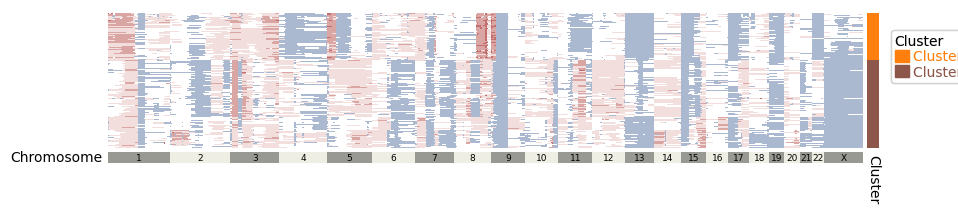

In [43]:
plt.figure(figsize=(10, 2))

col_ha = HeatmapAnnotation(
    Chromosome=anno_simple(
        cut_chroms.chromosome, add_text=True, colors=col, text_kws={"color": "black"}
    ),
    plot_legend=False,
    axis=1,
    rasterized=True,
    label_side="left",
    verbose=0,
)
row_ha = HeatmapAnnotation(
    Cluster=anno_simple(
        df_metacells.cluster,
        add_text=False,
        colors={
            "Cluster 1": sns.palettes.color_palette("tab10")[1],
            "Cluster 0": sns.palettes.color_palette("tab10")[5],
        },
    ),
    plot_legend=True,
    axis=0,
    rasterized=True,
    label_side="bottom",
)

cm1 = ClusterMapPlotter(
    data=metacells[cut_chroms.index],
    row_dendrogram=False,
    show_rownames=False,
    show_colnames=False,
    bottom_annotation=col_ha,
    right_annotation=row_ha,
    row_cluster_metric="cityblock",
    row_cluster_method="ward",
    col_cluster=False,
    row_cluster=True,
    label="Copy Number",
    cmap=newcmp,
    rasterized=True,
    legend=False,
    row_split=df_metacells.cluster,
    row_split_gap=0,
    row_split_order=["Cluster 1", "Cluster 0"],
)

plt.savefig("figures_rebuttal/hipsdr_for_defnd_metacells.png", dpi=300)
plt.savefig("figures_rebuttal/hipsdr_for_defnd_metacells.svg", dpi=300)
plt.show()